# Evaluate model skill
### This notebook runs the impact calculation for crowdsourced hail damage to buildings and compares it to observed damage

In [ ]:
#Load pacakges
import numpy as np
import datetime as dt

from climada.engine import ImpactCalc
from climada.hazard import Hazard
from climada import CONFIG
import scClim as sc
from scClim.constants import ID_COL_DICT

data_dir = str(CONFIG.local_data.data_dir)
out_dir = str(CONFIG.local_data.out_dir)


In [2]:
# Define parameters
haz_var = 'crowd'               # hazard variable
exp_var = 'KGV'                 # Exposure: 'Kantonale Gebäudeversicherung'
impf = 'emp_emanuel'            # Emanuel-type (sigmoidal) impact function
impf_fit_type = "flex_noBias"   # Fit with flexible exponent and minimized bias
version = 27                    # Version 2.7 of the gridding


# load data into CLIMADA objects
years = np.arange(2020,2023+1)
n_years = len(years)

c:\Users\timschmi\miniforge3\envs\climada_3_3\lib\pickle.py:1717: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)


<GeoAxes: title={'center': 'HL max intensity at each point'}>

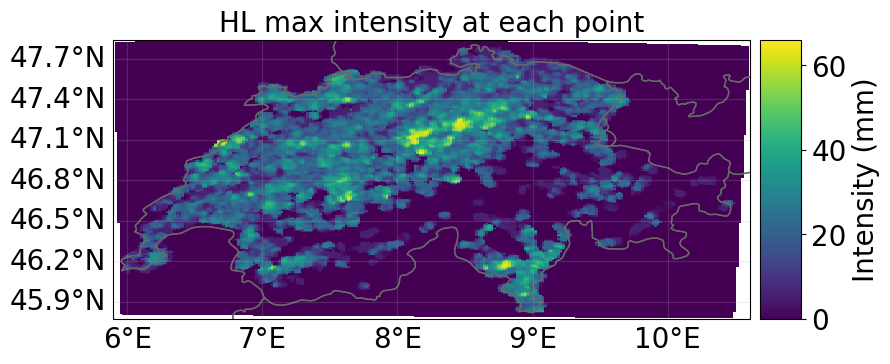

In [3]:
#Load hazard data
haz = Hazard.from_hdf5(f'{data_dir}/crowd-source/hazard_min25_2020+_V{version}.h5')
haz.plot_intensity(0)

In [ ]:
#Load exposure (per 1km grid point)
exp = sc.read_xr_exposure(data_dir+f'/KGV/ds_building_dmg_v71_1000m.nc',
                          'value_exposure')
exp_PAA = sc.read_xr_exposure(data_dir+f'/KGV/ds_building_dmg_v71_1000m.nc',
                              'n_count_exposure')

<GeoAxes: title={'center': 'Expected annual impact'}>

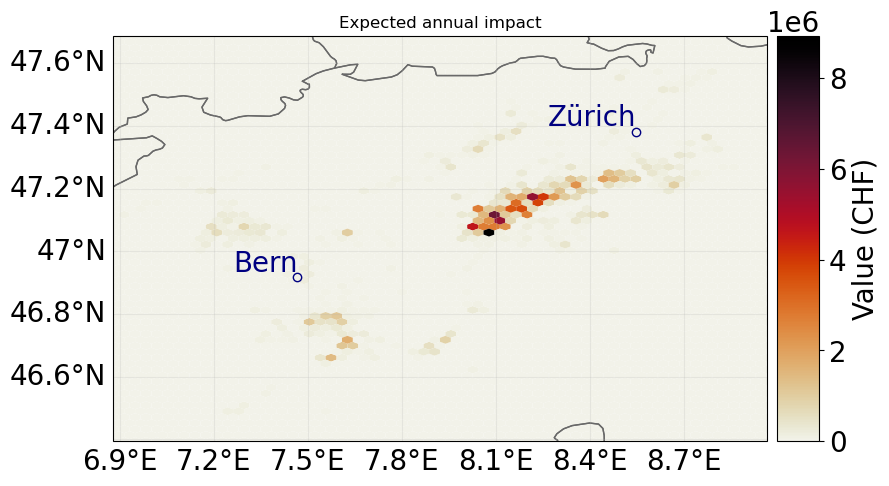

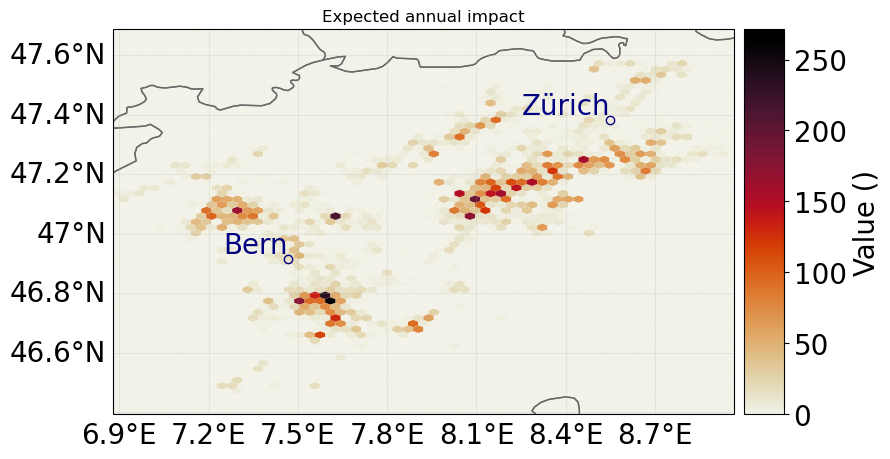

In [5]:
#Load impact data
index_dmgs = False #KGV exposure is already indexed

#Function which selects only hail season events and discard 2020 events before july
def filter_events(imp_measured):
    month= np.array([dt.datetime.fromordinal(d).month for d in imp_measured.date])
    year = np.array([dt.datetime.fromordinal(d).year for d in imp_measured.date])
    event_ids= imp_measured.event_id[((month>=4) & (month<=9)) & ~((month<=7) & (year==2020))]
    imp_measured = imp_measured.select(event_ids=event_ids)
    return imp_measured

#Load observed impact (per 1km grid point)
imp_path = (f"{data_dir}/{exp_var}/{exp_var}_Hail_Loss_date_corrected71.csv")
imp_measured = sc.read_gvz_dmg(imp_path, exp_var,return_type='imp',
                                years=(years[0],years[-1]),
                                baujahr_filter="",index_dmgs=index_dmgs,
                                crs='EPSG:4326',id_col=ID_COL_DICT[exp_var])

#Filter events and plot the data
imp_measured = filter_events(imp_measured)
imp_measured.plot_hexbin_eai_exposure(gridsize=60,linewidths=0,vmin=0)

#Load observed impact (per 1km grid point) for the number of damaged buildings
imp_measuredPAA = sc.read_gvz_dmg(imp_path,exp_var, return_type='imp',
                                    years=(years[0],years[-1]),
                                    exp_n_assets=True,index_dmgs=True,
                                    crs='EPSG:4326',id_col=ID_COL_DICT[exp_var])
imp_measuredPAA = filter_events(imp_measuredPAA)
imp_measuredPAA.plot_hexbin_eai_exposure(gridsize=60,linewidths=0,vmin=0)

In [6]:
print(f"Total damage in CHF: {imp_measured.at_event.sum().astype(int):,}")
print(f"Total number of claims: {imp_measuredPAA.at_event.sum().astype(int):,}")

Total damage in CHF: 689,767,165
Total number of claims: 64,886


In [7]:
#Load calibrated impact functions Vulnerability (impact functions)
impf_path = (f"{data_dir}/out_files/paa_mdd_smooth_KGVcrowdTEMP{impf_fit_type}_V{version}.csv")

# Function for the number of buildings
imp_fun_set_PAA = sc.impf_from_csv(impf_path,PAA_only=True,smooth=False,
                                    emanuel_fit=True,plot=False)
# Function for the value of buildings
imp_fun_set = sc.impf_from_csv(impf_path, smooth=False,
                                emanuel_fit=True, plot=False)


In [8]:
#Calculate the impact
imp = ImpactCalc(exp,imp_fun_set,haz).impact(save_mat=True)
imp_PAA = ImpactCalc(exp_PAA, imp_fun_set_PAA, haz).impact(save_mat=True)

<GeoAxes: title={'center': 'Expected annual impact'}>

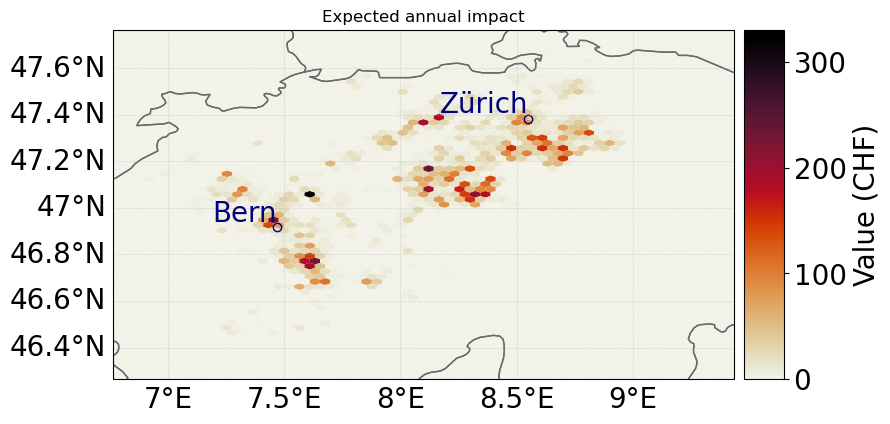

In [9]:
#Plot the expected annual impact
imp_PAA.plot_hexbin_eai_exposure(gridsize=60,linewidths=0,vmin=0)

In [10]:
#Save impact objects
imp.write_hdf5(f"{data_dir}/crowd-source/imp_dfs/V{version}_MDR{impf_fit_type}.hdf5")
imp_PAA.write_hdf5(f"{data_dir}/crowd-source/imp_dfs/V{version}_PAA{impf_fit_type}.hdf5")

In [ ]:
#Save impact data to csv
for imp_now, imp_obs_now,dmg_thresh,xmin,imp_type in zip([imp,imp_PAA],
                                                [imp_measured,imp_measuredPAA],
                                                [1e5,1e2],[1e2,1],['MDR','PAA']):

    #create impact dataframe with modelled and reported impacts per event (day)
    #get all dates with modelled OR reported damages above xmin

    imp_df = sc.E.create_imp_df(imp_now,imp_obs_now,xmin)
    imp_df = imp_df.drop(columns=['prePost2012'])
    imp_df.to_csv(f"{data_dir}/crowd-source/imp_dfs/V{version}_{imp_type}{impf_fit_type}.csv")
